In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F


In [156]:
# laod the prediction results
path_run = "../models/checkpoints/run_14"
predictions = pd.read_csv(f"{path_run}/results.csv")
predictions.sort_values(by="BLEU Score", ascending=False, inplace=True)

# select best prediction for each image
best_predictions = predictions.loc[predictions.groupby('Image Name')['BLEU Score'].idxmax()]
best_predictions.sort_values(by="BLEU Score", ascending=False, inplace=True)

FileNotFoundError: [Errno 2] No such file or directory: '../models/checkpoints/run_14/results.csv'

In [88]:
# show image with true caption and predicted caption 

def show_image(image_name):
    path = "../data/raw/images/"
    true_caption = best_predictions.loc[best_predictions['Image Name'] == image_name, 'True Caption'].values[0]
    predicted_caption = best_predictions.loc[best_predictions['Image Name'] == image_name, 'Predicted Caption'].values[0]
    
    plt.figure(figsize=(10, 8))
    plt.imshow(Image.open(f"{path}/{image_name}"))
    plt.title(f"True Caption: {true_caption.replace('  ', '')}\nPredicted Caption: {predicted_caption.strip()}",fontsize=12, pad=10, wrap=True)
    plt.axis('off')
    plt.show()
    

 two dogs play in grass                                                                          .
nearby empty throwing walk by two .


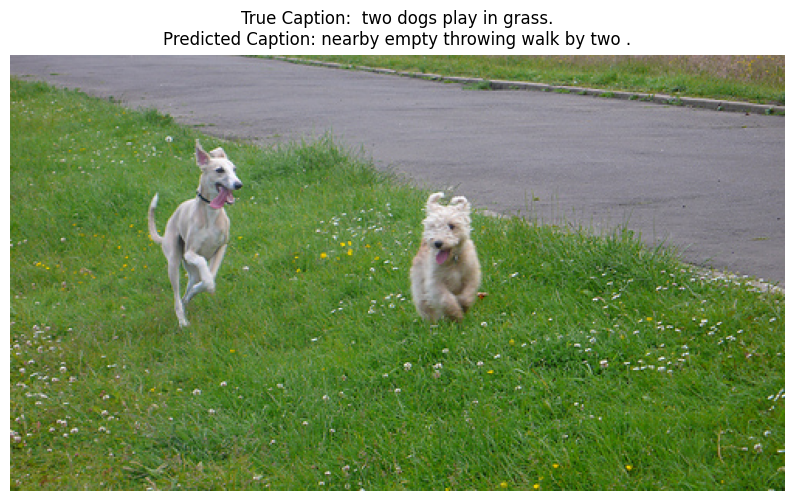

In [93]:
show_image(best_predictions['Image Name'].iloc[10])


In [157]:
import torch
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import transforms
import pandas as pd
from tqdm import tqdm

from utils.config import Config
from models.base import ImageCaptioningModel
from models.attention_model import ImageCaptioningWithAttention
from data.data_set import DataSet
from text.tokenizer import Tokenizer
from pathlib import Path

run_id = 14
MODEL_PATH = Path(f"../models/checkpoints/run_{run_id}")

config = Config(experiment_id=run_id)
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

model = ImageCaptioningWithAttention(config.embed_size, config.attention_dim, config.decoder_dim, config.vocab_size, config.encoder_dim).to(device)
model.load_state_dict(torch.load(f"{MODEL_PATH}/best_model.pth", map_location=device, weights_only=True))

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
tokenizer = Tokenizer()
tokenizer.load_dicts("../data/processed/dicts.pkl")

test_set = DataSet("../data/processed", transform, tokenizer, data_type="test")
test_loader = DataLoader(test_set, batch_size=8, shuffle=False)


In [158]:
image = test_set[0][0]
with torch.no_grad():
    features = model.encoder(image.unsqueeze(0).to(device))
    
    caption = [tokenizer.word_to_idx['<start>']]
            
    for _ in range(config.max_length):
        inputs = torch.tensor([caption]).to(device)
        outputs = model.decoder(features, inputs)
        temperature = 0.8  
        probs = torch.softmax(outputs[:, -1, :] / temperature, dim=-1)
        word = torch.multinomial(probs, 1).item()
        caption.append(word)
        if word == tokenizer.word_to_idx['<end>']:
            break

    predicted_text = ' '.join([tokenizer.idx_to_word[idx] for idx in caption])

In [141]:
def visualize_features_overlay(image, true_caption, model, alpha=0.6):
    """
    Visualize mean feature activation overlaid on the original image
    """
    with torch.no_grad():
        features = model.encoder(image.unsqueeze(0).to(device))
        caption = [tokenizer.word_to_idx['<start>']]
            
        for _ in range(config.max_length):
            inputs = torch.tensor([caption]).to(device)
            outputs = model.decoder(features, inputs)
            temperature = 0.8  
            probs = torch.softmax(outputs[:, -1, :] / temperature, dim=-1)
            word = torch.multinomial(probs, 1).item()
            caption.append(word)
            if word == tokenizer.word_to_idx['<end>']:
                break

        predicted_text = ' '.join([tokenizer.idx_to_word[idx] for idx in caption])

        mean_features = features.mean(dim=1).squeeze().cpu()
        mean_features = (mean_features - mean_features.min()) / (mean_features.max() - mean_features.min())

        plt.figure(figsize=(10, 8))

        img_np = image.permute(1, 2, 0).cpu().numpy()
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())  # Normalize to [0,1]
        plt.imshow(img_np)
        
        mean_features_resized = F.interpolate(
            mean_features.unsqueeze(0).unsqueeze(0), 
            size=img_np.shape[:2], 
            mode='bilinear', 
            align_corners=False
        ).squeeze().numpy()
        
        plt.imshow(mean_features_resized, cmap='hot', alpha=alpha)
        plt.title(f'Feature Activation Overlay\nPredicted Caption: {post_process_caption(predicted_text)}\nTrue Caption: {true_caption}')
        plt.axis('off')
        plt.show()
        
def post_process_caption(caption, type="prediction"):
    """
    Apply post-processing to the generated caption
    """
    if not caption.endswith('.'):
        caption = caption + '.'
        
    # Drop <pad> , <end> , <start>
    caption = caption.replace('<pad>', '').replace('<end>', '').replace('<start>', '')
        
    if type == "prediction":
        # Remove duplicate consecutive words
        words = caption.split()
        words = [word for word in words if words.count(word) == 1]
        caption = ' '.join(words)
    
    return caption

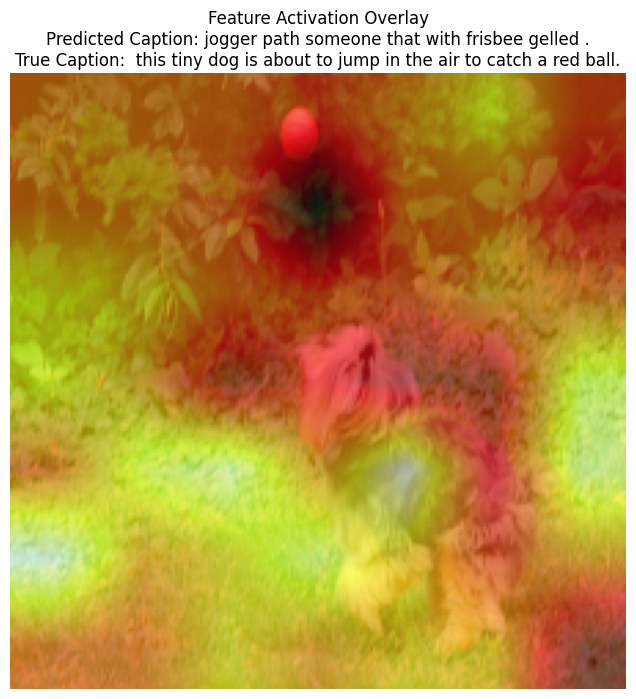

In [171]:
index = 18
image = test_set[index][0]
true_caption = post_process_caption(tokenizer.decode_caption(test_set[index][1]), type="true").replace('  ', '')
visualize_features_overlay(image, true_caption, model)

